In [1]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
X, y = make_blobs(n_samples=100_000, n_features=2, cluster_std=.5, center_box=(- 10.0, 10.0), shuffle=True, random_state=None)

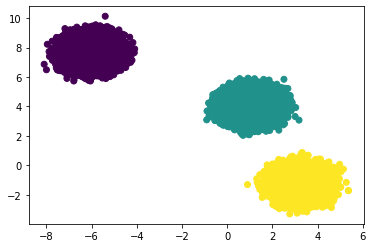

In [3]:
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [7]:
from sklearn.cluster import DBSCAN
import multiprocessing

t0 = time.perf_counter()
clustering = DBSCAN(eps=.5, min_samples=5, n_jobs=-1).fit(X)
python_time = time.perf_counter() - t0
print(f'Elapsed time {python_time}s with {multiprocessing.cpu_count()} cpu')
clustering.labels_

Elapsed time 12.293413750000127s with 2 cpu


array([0, 1, 1, ..., 1, 1, 1])

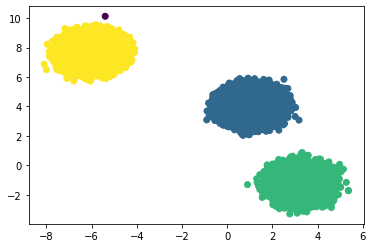

In [5]:
plt.scatter(X[:, 0], X[:, 1], c=clustering.labels_)
plt.show()

In [6]:
from sklearn import metrics

metrics.adjusted_rand_score(y, clustering.labels_)

0.9999849997749907